# Preliminary Imports

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import albumentations as A
import segmentation_models_pytorch as smp

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Data Exploration

In [17]:
# Define paths
data_dir = Path('data')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [18]:
# Sample code to inspect one frame-mask pair
sample_frame = np.load(train_dir / 'video_01_frame_1.npy')
sample_mask = np.load(train_dir / 'video_01_mask_1.npy')

In [19]:
print(f"Frame shape: {sample_frame.shape}, dtype: {sample_frame.dtype}")
print(f"Mask shape: {sample_mask.shape}, unique values: {np.unique(sample_mask)}")

Frame shape: (1080, 1920, 3), dtype: uint8
Mask shape: (1080, 1920), unique values: [0 1 2 3 5 8]


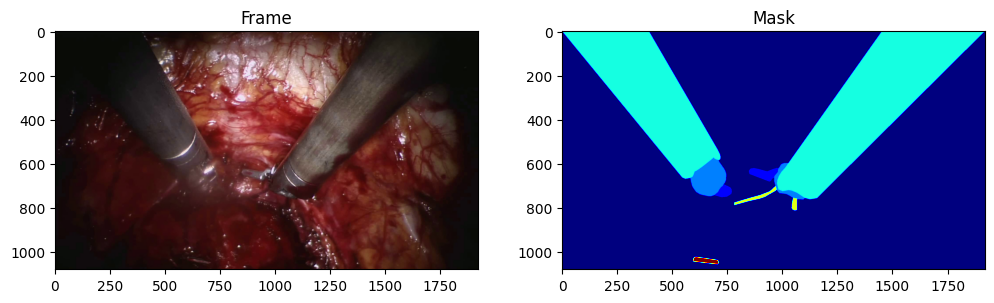

In [20]:
# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_frame)
plt.title('Frame')
plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='jet')
plt.title('Mask')
plt.show()

# Data Pipeline

In [21]:
class SurgicalDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform

        # Set the corresponding directory for the split
        self.split_dir = data_dir / self.split

        # Print to verify correct directory
        print(f"Loading from directory: {self.split_dir}")
        
        # List of all frame and mask files in the split directory
        self.frame_files = sorted(self.split_dir.glob('video_*_frame_*.npy'))  # Adjusted pattern
        self.mask_files = sorted(self.split_dir.glob('video_*_mask_*.npy'))  # Adjusted pattern

        # Check if the frames and masks match
        assert len(self.frame_files) == len(self.mask_files), "Mismatch between frames and masks"

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        # Load frame and mask
        frame_path = self.frame_files[idx]
        mask_path = self.mask_files[idx]

        frame = np.load(frame_path)
        mask = np.load(mask_path)

        # Normalize frame (from 0-255 to 0-1)
        frame = frame.astype(np.float32) / 255.0
        
        # Check the dimensions and ensure frame and mask match
        assert frame.shape[:2] == mask.shape, f"Frame shape {frame.shape} doesn't match Mask shape {mask.shape}"

        # Apply transformations if any
        if self.transform:
            augmented = self.transform(image=frame, mask=mask)
            frame = augmented['image']
            mask = augmented['mask']

        return frame, mask

In [24]:
def get_transform(augment=False):
    if augment:
        return A.Compose([
            A.HorizontalFlip(p=0.5),  # Flip with 50% probability
            A.Resize(512, 512), # Remove dimensionality for faster computations.
            ToTensorV2()  # Convert to PyTorch tensor
        ])
    else:
        return A.Compose([
            A.Resize(512, 512), # Remove dimensionality for faster computations.
            ToTensorV2()  # Convert to PyTorch tensor
        ])

In [25]:
train_transform = get_transform(augment=False)  # Set to True for augmentations
train_dataset = SurgicalDataset(data_dir, split='train', transform=train_transform)

Loading from directory: data\train


In [34]:
len(train_dataset)

10270

In [58]:
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [59]:
# Get a sample
frame, mask = train_dataset[0]
print(f"Frame shape: {frame.shape}, Mask shape: {mask.shape}")

Frame shape: torch.Size([3, 512, 512]), Mask shape: torch.Size([512, 512])


In [60]:
len(train_loader)

642

# Model Implementation

In [61]:
model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g. 'resnet34'
    encoder_weights='imagenet',     # Use pre-trained weights
    in_channels=3,                  # RGB channels
    classes=10                      # Number of segmentation classes
)

In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [63]:
model.train()
train_loss = 0.0
for images, masks in tqdm(train_loader):
    outputs = model(images)
    loss = loss_fn(outputs, masks.long())
    optimizer.zero_grad()
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████| 642/642 [4:08:49<00:00, 23.26s/it]


In [ ]:
model.eval()
val_loss = 0.0
val_iou = 0.0

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, masks.long())

        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        val_iou += compute_iou(preds, masks, num_classes=10)

avg_val_loss = val_loss / len(val_loader)
avg_val_iou = val_iou / len(val_loader)

print(f"Validation Loss: {avg_val_loss:.4f}, Validation mIoU: {avg_val_iou:.4f}")

In [65]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader):
        images = images
        masks = masks

        outputs = model(images)
        loss = loss_fn(outputs, masks.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Run validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images
            masks = masks

            outputs = model(images)
            loss = loss_fn(outputs, masks.long())

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_iou += compute_iou(preds, masks, num_classes=10)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"Validation Loss: {avg_val_loss:.4f}, mIoU: {avg_val_iou:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 642/642 [3:17:13<00:00, 18.43s/it]


Epoch [1/1], Train Loss: 0.1591


NameError: name 'val_loader' is not defined

In [66]:
def compute_iou(preds, masks, num_classes):
    iou = 0.0
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            continue  # Skip classes not present in ground truth or prediction
        iou += intersection / union

    return iou / num_classes

In [67]:
val_transform = get_transform(augment=False)  # Set to True for augmentations
val_dataset = SurgicalDataset(data_dir, split='val', transform=val_transform)

Loading from directory: data\val


In [68]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [72]:
model.eval()
val_loss = 0.0
val_iou = 0.0

with torch.no_grad():
    for images, masks in val_loader:
        outputs = model(images)
        loss = loss_fn(outputs, masks.long())

        val_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        val_iou += compute_iou(preds, masks, num_classes=10)

avg_val_loss = val_loss / len(val_loader)
avg_val_iou = val_iou / len(val_loader)

print(f"Validation Loss: {avg_val_loss:.4f}, mIoU: {avg_val_iou:.4f}")

Validation Loss: 0.1323, mIoU: 0.4663


In [73]:
train_transform = get_transform(augment=True)  # Set to True for augmentations
train_dataset = SurgicalDataset(data_dir, split='train', transform=train_transform)

Loading from directory: data\train


In [74]:
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [92]:
val_transform = get_transform(augment=False)
val_dataset = SurgicalDataset(data_dir, split='val', transform=val_transform)

Loading from directory: data\val


In [93]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [77]:
model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g. 'resnet34'
    encoder_weights='imagenet',     # Use pre-trained weights
    in_channels=3,                  # RGB channels
    classes=10                      # Number of segmentation classes
)

In [78]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [79]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader):
        images = images
        masks = masks

        outputs = model(images)
        loss = loss_fn(outputs, masks.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Run validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images
            masks = masks

            outputs = model(images)
            loss = loss_fn(outputs, masks.long())

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_iou += compute_iou(preds, masks, num_classes=10)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"Validation Loss: {avg_val_loss:.4f}, mIoU: {avg_val_iou:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 642/642 [2:38:51<00:00, 14.85s/it]


Epoch [1/1], Train Loss: 0.6507


ValueError: expected 4D input (got 3D input)

In [94]:
model.eval()
val_loss = 0.0
val_iou = 0.0

with torch.no_grad():
    for images, masks in val_loader:
        images = images
        masks = masks

        outputs = model(images)
        loss = loss_fn(outputs, masks.long())

        val_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        val_iou += compute_iou(preds, masks, num_classes=10)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"Validation Loss: {avg_val_loss:.4f}, mIoU: {avg_val_iou:.4f}")

Validation Loss: 0.1967, mIoU: 0.3985


In [95]:
train_transform = get_transform(augment=False)  # Set to True for augmentations
train_dataset = SurgicalDataset(data_dir, split='train', transform=train_transform)

Loading from directory: data\train


In [96]:
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [97]:
val_transform = get_transform(augment=False)
val_dataset = SurgicalDataset(data_dir, split='val', transform=val_transform)

Loading from directory: data\val


In [98]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [99]:
model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g. 'resnet34'
    encoder_weights='imagenet',     # Use pre-trained weights
    in_channels=3,                  # RGB channels
    classes=10                      # Number of segmentation classes
)

In [100]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader):
        images = images
        masks = masks

        outputs = model(images)
        loss = loss_fn(outputs, masks.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Run validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images
            masks = masks

            outputs = model(images)
            loss = loss_fn(outputs, masks.long())

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_iou += compute_iou(preds, masks, num_classes=10)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"Validation Loss: {avg_val_loss:.4f}, mIoU: {avg_val_iou:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 642/642 [2:42:21<00:00, 15.17s/it]


Epoch [1/2], Train Loss: 0.6001
Validation Loss: 0.2014, mIoU: 0.3388


 51%|██████████████████████████████████████▋                                     | 327/642 [1:40:47<1:30:12, 17.18s/it]

In [ ]:
train_transform = get_transform(augment=True)  # Set to True for augmentations
train_dataset = SurgicalDataset(data_dir, split='train', transform=train_transform)

In [ ]:
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
val_transform = get_transform(augment=False)
val_dataset = SurgicalDataset(data_dir, split='val', transform=val_transform)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g. 'resnet34'
    encoder_weights='imagenet',     # Use pre-trained weights
    in_channels=3,                  # RGB channels
    classes=10                      # Number of segmentation classes
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader):
        images = images
        masks = masks

        outputs = model(images)
        loss = loss_fn(outputs, masks.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Run validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images
            masks = masks

            outputs = model(images)
            loss = loss_fn(outputs, masks.long())

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_iou += compute_iou(preds, masks, num_classes=10)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"Validation Loss: {avg_val_loss:.4f}, mIoU: {avg_val_iou:.4f}")